In [142]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.circuit import Qubit, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-05-30 14:38:59,240: Credentials are already in use. The existing account in the session will be replaced.


### Zadanie 1
Algorytm Grovera dla n = 2, porównanie implementacji z Marmina i rozwiązania z optymalizacjami pod IBM  
Najpierw konstruuję obwód jaki został opisany w książce: 

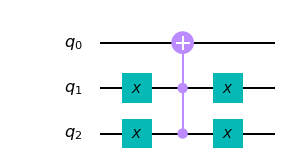

In [54]:
# Wyrocznia z zakodowanym 00  
oracle1 = QuantumCircuit(3)
oracle1.x(1)
oracle1.x(2)
oracle1.ccx(2,1,0)
oracle1.x(1)
oracle1.x(2)
oracle1.draw()

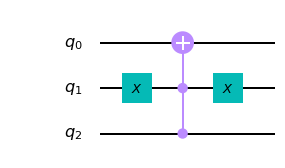

In [55]:
# Wyrocznia z zakodowanym 10
oracle2 = QuantumCircuit(3)
oracle2.x(1)
oracle2.ccx(2,1,0)
oracle2.x(1)
oracle2.draw()

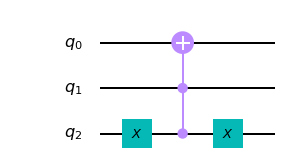

In [56]:
# Wyrocznia z zakodowanym 01
oracle3 = QuantumCircuit(3)
oracle3.x(2)
oracle3.ccx(2,1,0)
oracle3.x(2)
oracle3.draw()

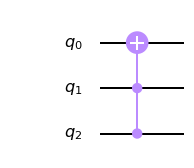

In [57]:
# Wyrocznia z zakodowanym 00
oracle4 = QuantumCircuit(3)
oracle4.ccx(2,1,0)
oracle4.draw()

In [58]:
marmin_oracles = [oracle1, oracle3, oracle2, oracle4]

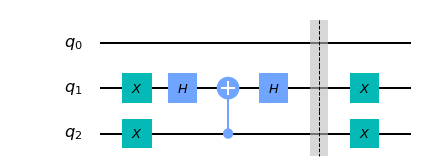

In [59]:
# Układ dokonujący inwersji
inversion = QuantumCircuit(3)

inversion.x(1)
inversion.x(2)
inversion.h(1)
inversion.cx(2,1)
inversion.h(1)
inversion.barrier()
inversion.x(1)
inversion.x(2)
inversion.draw()

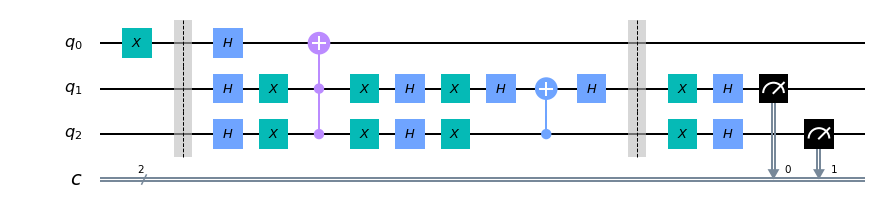

In [60]:
def marmin_circuit(oracle):
    hadamards = QuantumCircuit(3)
    hadamards.h(1)
    hadamards.h(2)
    
    circuit = QuantumCircuit(3,2)
    circuit.x(0) #rejestr wyjściowy ustawiany na 1
    circuit.barrier()
    circuit.h(0)
    circuit = circuit + hadamards + oracle + hadamards + inversion + hadamards
    circuit.measure([1,2], [0,1])
    return circuit;

marmin_circuit(marmin_oracles[0]).draw()

Obwód z optymalizacjami IBM:

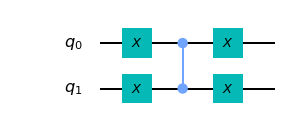

In [61]:
# wyrocznia z zakodowanym 00
oracle1 = QuantumCircuit(2)
oracle1.x(0)
oracle1.x(1)
oracle1.cz(0,1)
oracle1.x(0)
oracle1.x(1)
oracle1.draw()

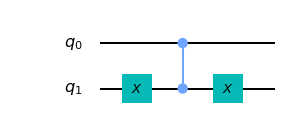

In [62]:
# wyrocznia z zakodowanym 01
oracle2 = QuantumCircuit(2)
oracle2.x(1)
oracle2.cz(0,1)
oracle2.x(1)
oracle2.draw()

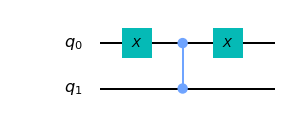

In [63]:
# wyrocznia z zakodowanym 10
oracle3 = QuantumCircuit(2)
oracle3.x(0)
oracle3.cz(0,1)
oracle3.x(0)
oracle3.draw()

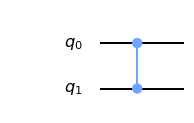

In [64]:
# wyrocznia z zakodowanym 11
oracle4 = QuantumCircuit(2)
oracle4.cz(0,1)
oracle4.draw()

In [65]:
ibm_oracles = [oracle1, oracle2, oracle3, oracle4]

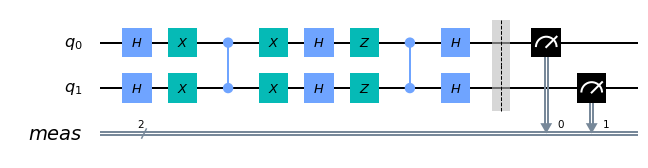

In [66]:
def ibm_circuit(oracle):
    n = 2
    grover_circuit = QuantumCircuit(n)
    for qubit in range(n):
        grover_circuit.h(qubit)
    grover_circuit += oracle
    for qubit in range(n):
        grover_circuit.h(qubit)
    for qubit in range(n):
        grover_circuit.z(qubit)
    grover_circuit.cz(0, 1)
    for qubit in range(n):
        grover_circuit.h(qubit)
    grover_circuit.measure_all()
    return grover_circuit

ibm_circuit(ibm_oracles[0]).draw() 

Porównanie wyników układów na symulatorze quasm:

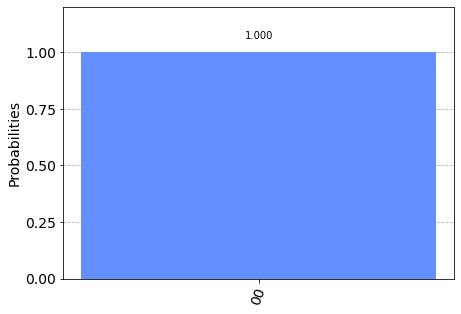

In [67]:
def run(circuit):
    results = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024).result()
    return plot_histogram(results.get_counts())
    
run(marmin_circuit(marmin_oracles[0]))

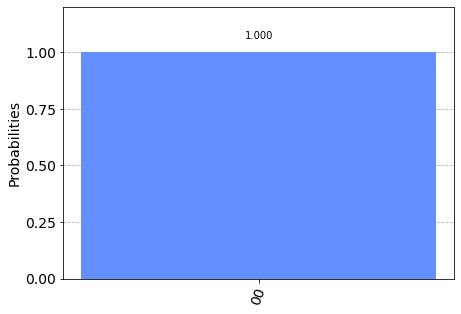

In [68]:
run(ibm_circuit(ibm_oracles[0]))

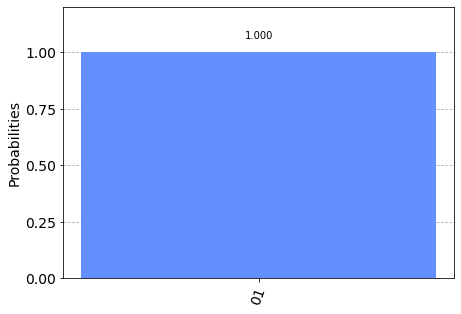

In [69]:
run(marmin_circuit(marmin_oracles[1]))

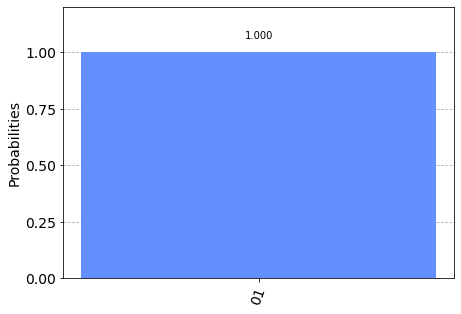

In [70]:
run(ibm_circuit(ibm_oracles[1]))

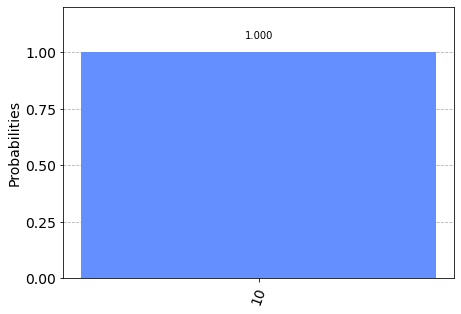

In [71]:
run(marmin_circuit(marmin_oracles[2]))

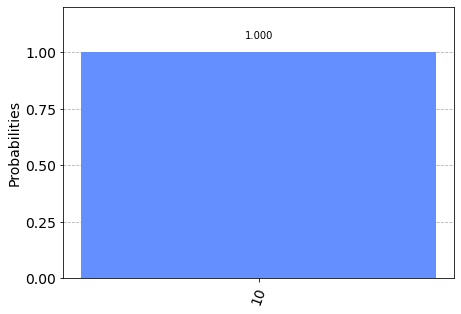

In [72]:
run(ibm_circuit(ibm_oracles[2]))

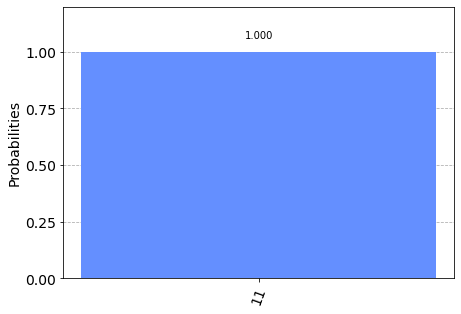

In [73]:
run(marmin_circuit(marmin_oracles[3]))

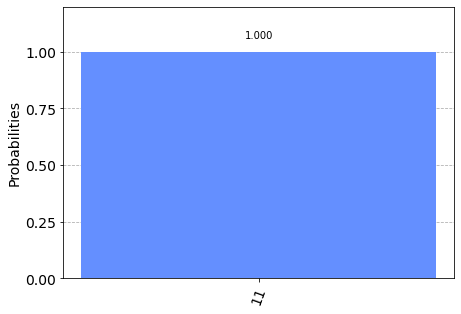

In [74]:
run(ibm_circuit(ibm_oracles[3]))

Jak widać na teoretycznym symulatorze quasm wyniki wychodzą spodziewane i równoważne dla obydwu obwodów. W wypadku obwodu 'książkowego' pomiar dokonywany jest tylko a rejestrze wejściowym |q3 q2>, w wypadku optymalizacji IBM pominięty jest rejestr wyjściowy więc mierzę wszystkie qubity.

In [77]:
def run(circuit):
    results = execute(circuit, provider.get_backend('ibmq_16_melbourne')).result()
    return plot_histogram(results.get_counts())

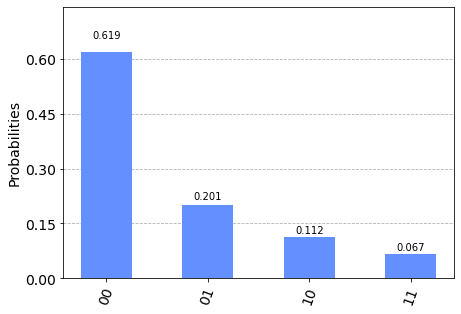

In [78]:
run(marmin_circuit(marmin_oracles[0]))

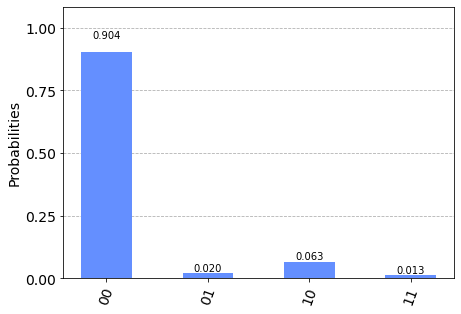

In [79]:
run(ibm_circuit(ibm_oracles[0]))

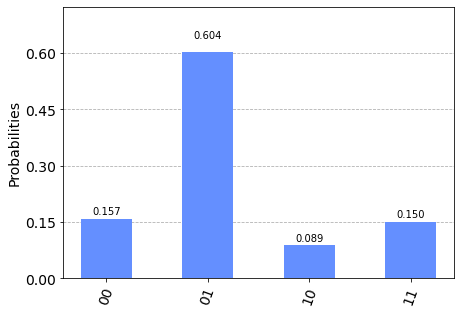

In [80]:
run(marmin_circuit(marmin_oracles[1]))

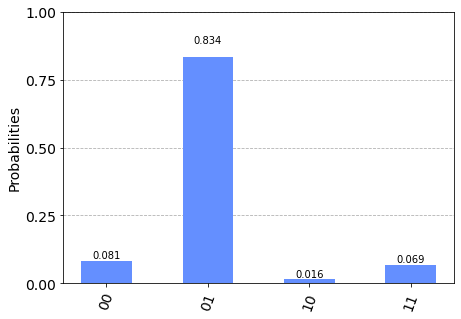

In [81]:
run(ibm_circuit(ibm_oracles[1]))

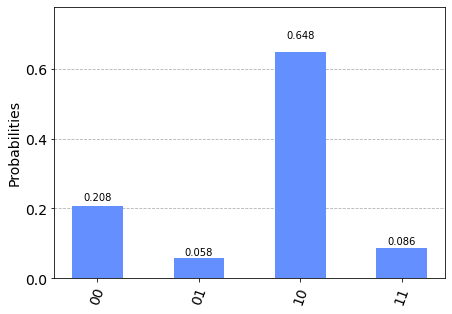

In [82]:
run(marmin_circuit(marmin_oracles[2]))

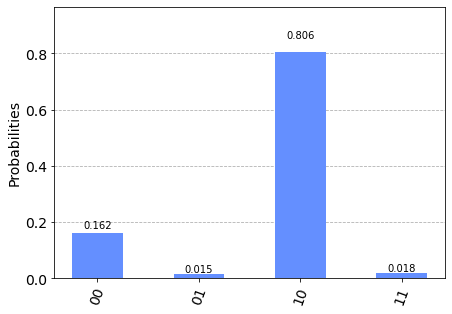

In [83]:
run(ibm_circuit(ibm_oracles[2]))

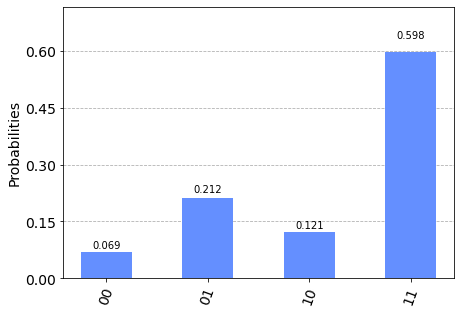

In [84]:
run(marmin_circuit(marmin_oracles[3]))

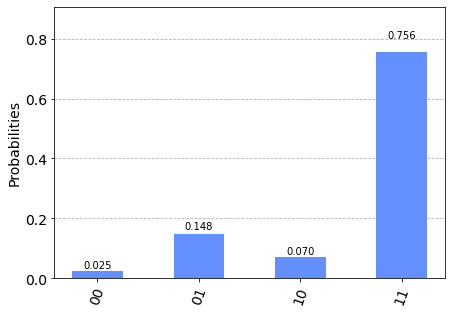

In [85]:
run(ibm_circuit(ibm_oracles[3]))

Uruchamiając obwód na prawdziwym urządzeniu kwantowym widać wpływ optymalizacji IBM na wynik. W przypadku układu książkowego oczekiwana liczba otrzymywana jest z 60-65% prawdopodobieństwem, a w przypadku zoptymalizowanym z 75-90%. Jest to związane z liczbą bramek które są faktycznie wykorzystane, bo bramki są w rzczywistości budowane z kilku bramek, a optymalizacje mają na celu zminimalizować tę liczbę minimalizując tym samym wpływ dekoherencji na wynik. 

### Zadanie2
Demonstracja działania algorytmu Grovera dla n =5, implementacja korzystająca z opymalizacji pod IBM, zakodowaną liczbą jest|10111> czyli 23

In [188]:
import math

#bramka cz na 5 bitach
def ccz(circuit):
    circuit.h(4)
    circuit.mcx([0,1,2,3],4)
    circuit.h(4)

# wyrocznia z liczbą |10111> 
def oracle(circuit):
    circuit.x(3)
    ccz(circuit)
    circuit.x(3)

In [189]:
def inversion(circuit):
    qubits = circuit.qubits
    nqubits = len(qubits)
    for q in range(nqubits):
        circuit.h(q)
        circuit.x(q)
        
    ccz(circuit)
    
    for q in range(nqubits):
        circuit.x(q)
        circuit.h(q)

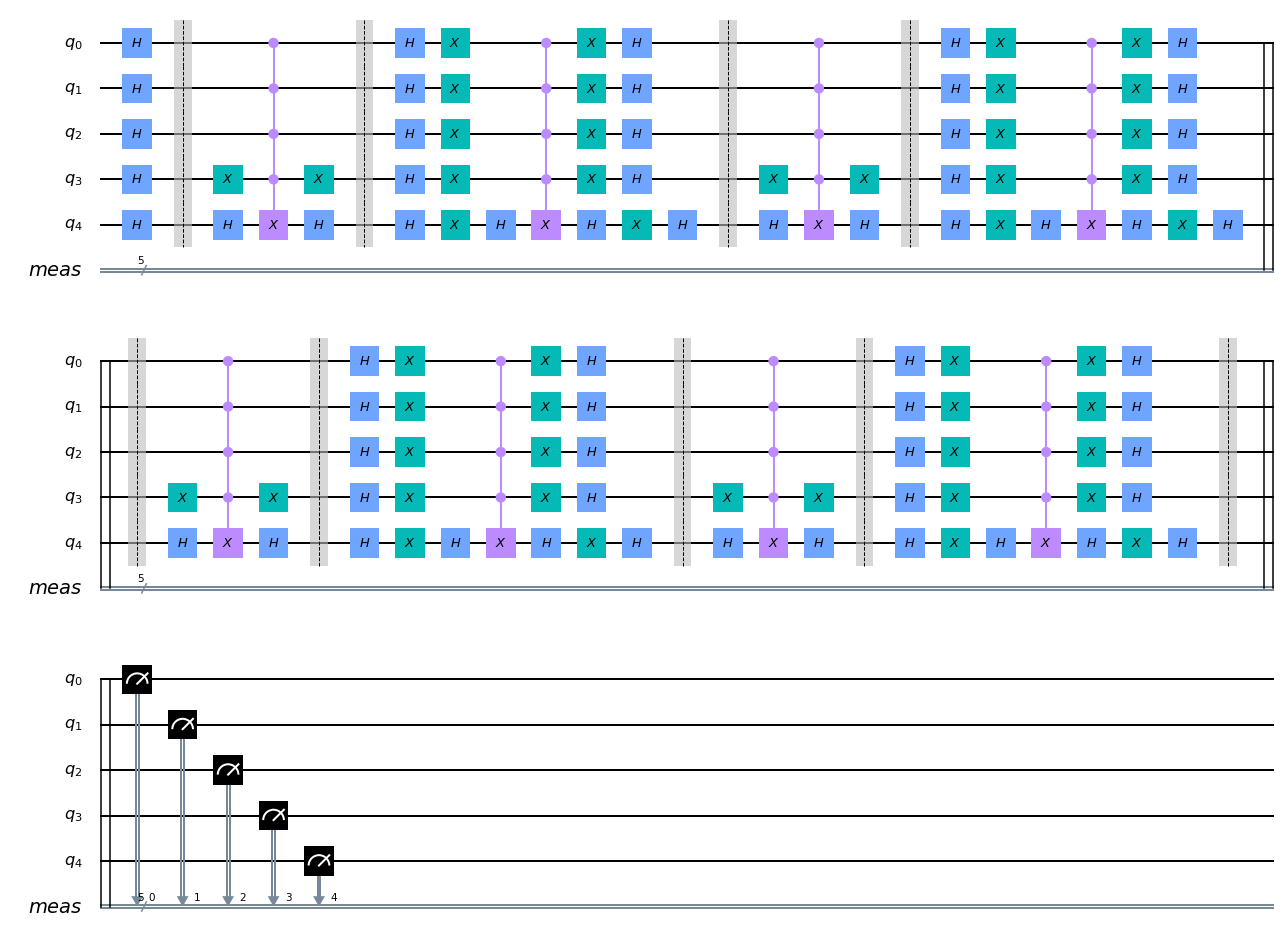

In [197]:
def iteration(circuit):
    circuit.barrier()
    oracle(circuit)
    circuit.barrier()
    inversion(circuit)


grover_circuit = QuantumCircuit(5)

for qubit in range(n):
    grover_circuit.h(qubit)

# 4 iteracje algorytmu
for i in range(4):
    iteration(grover_circuit)


grover_circuit.measure_all()
grover_circuit.draw()

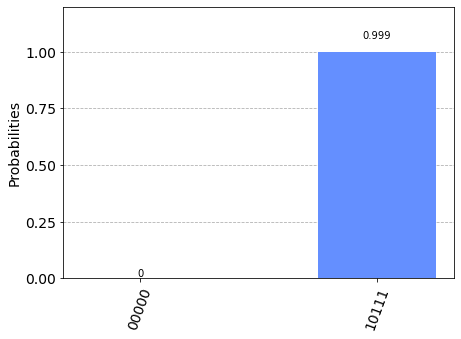

In [201]:
results = execute(grover_circuit, Aer.get_backend('qasm_simulator'), shots=1024).result()
plot_histogram(results.get_counts())

Dla 4 iteracji grovera otrzymałam szukaną liczbę z prawdopodobieństwem niemal równym 1. Zgadza się to z podanym wzorem, bo pi/4 * sqrt(2^5) ~= 4,44. Rozbijając układ na kawałki i mierząc w różnych momentach mamy:   
  
1.1. iteracja pierwsza po wyroczni:

In [240]:
import numpy as np

def print_amplitudes(statevector):
    statevector = [np.linalg.norm(o) for o in statevector]
    for i in range(len(statevector)):
        print("state " + str(i) + " --> amplitude " + str(statevector[i]))

grover_circuit = QuantumCircuit(5)

for qubit in range(n):
    grover_circuit.h(qubit)
    
grover_circuit.barrier()
oracle(grover_circuit)

backend = Aer.get_backend('statevector_simulator')
outputstate1 = execute(grover_circuit, backend).result().get_statevector(grover_circuit)
print_amplitudes(outputstate1)
print(outputstate1)

state 0 --> amplitude 0.1767766952966369
state 1 --> amplitude 0.1767766952966369
state 2 --> amplitude 0.1767766952966369
state 3 --> amplitude 0.1767766952966369
state 4 --> amplitude 0.1767766952966369
state 5 --> amplitude 0.1767766952966369
state 6 --> amplitude 0.1767766952966369
state 7 --> amplitude 0.17677669529663684
state 8 --> amplitude 0.1767766952966369
state 9 --> amplitude 0.1767766952966369
state 10 --> amplitude 0.1767766952966369
state 11 --> amplitude 0.17677669529663687
state 12 --> amplitude 0.1767766952966369
state 13 --> amplitude 0.17677669529663687
state 14 --> amplitude 0.17677669529663687
state 15 --> amplitude 0.17677669529663684
state 16 --> amplitude 0.17677669529663687
state 17 --> amplitude 0.17677669529663687
state 18 --> amplitude 0.17677669529663687
state 19 --> amplitude 0.17677669529663687
state 20 --> amplitude 0.17677669529663687
state 21 --> amplitude 0.17677669529663687
state 22 --> amplitude 0.17677669529663687
state 23 --> amplitude 0.1767766

Wyrocznia nie wpływa na amplitudy stanów, za to stan wyróżniony zostaje zanegowany (|10111> czyli 23)  
  
1.2. iteracja pierwsza po inwersji:

In [241]:
inversion(grover_circuit)

outputstate2 = execute(grover_circuit, backend).result().get_statevector(grover_circuit)
print_amplitudes(outputstate2)
print(outputstate2)

state 0 --> amplitude 0.1546796083845574
state 1 --> amplitude 0.15467960838455733
state 2 --> amplitude 0.1546796083845573
state 3 --> amplitude 0.15467960838455724
state 4 --> amplitude 0.1546796083845573
state 5 --> amplitude 0.15467960838455724
state 6 --> amplitude 0.15467960838455722
state 7 --> amplitude 0.15467960838455727
state 8 --> amplitude 0.15467960838455733
state 9 --> amplitude 0.15467960838455724
state 10 --> amplitude 0.15467960838455722
state 11 --> amplitude 0.15467960838455716
state 12 --> amplitude 0.15467960838455722
state 13 --> amplitude 0.15467960838455716
state 14 --> amplitude 0.1546796083845572
state 15 --> amplitude 0.15467960838455713
state 16 --> amplitude 0.15467960838455733
state 17 --> amplitude 0.1546796083845573
state 18 --> amplitude 0.15467960838455722
state 19 --> amplitude 0.15467960838455722
state 20 --> amplitude 0.15467960838455722
state 21 --> amplitude 0.15467960838455722
state 22 --> amplitude 0.15467960838455713
state 23 --> amplitude 0.5

Inwersja wzmacnia stan wyróżniony w wyroczni (stan |10111> ma amplitudę 0.508, a reszta stanów 0.155)  
  
2.1. iteracja druga po wyroczni

In [242]:
oracle(grover_circuit)

outputstate3 = execute(grover_circuit, backend).result().get_statevector(grover_circuit)
print_amplitudes(outputstate3)
print(outputstate3)

state 0 --> amplitude 0.1546796083845574
state 1 --> amplitude 0.15467960838455733
state 2 --> amplitude 0.1546796083845573
state 3 --> amplitude 0.15467960838455724
state 4 --> amplitude 0.1546796083845573
state 5 --> amplitude 0.15467960838455724
state 6 --> amplitude 0.15467960838455722
state 7 --> amplitude 0.1546796083845572
state 8 --> amplitude 0.15467960838455733
state 9 --> amplitude 0.15467960838455724
state 10 --> amplitude 0.15467960838455722
state 11 --> amplitude 0.15467960838455716
state 12 --> amplitude 0.15467960838455722
state 13 --> amplitude 0.15467960838455716
state 14 --> amplitude 0.1546796083845572
state 15 --> amplitude 0.15467960838455713
state 16 --> amplitude 0.15467960838455733
state 17 --> amplitude 0.1546796083845573
state 18 --> amplitude 0.15467960838455722
state 19 --> amplitude 0.15467960838455722
state 20 --> amplitude 0.15467960838455722
state 21 --> amplitude 0.15467960838455722
state 22 --> amplitude 0.15467960838455713
state 23 --> amplitude 0.50

Ponownie widać, że wyrocznia nie wpłynęła na amplitudy, ale wyróżniony stan znowu zmienił znak  
  
2.2 teracja druga po inwersji:

In [244]:
inversion(grover_circuit)

outputstate4 = execute(grover_circuit, backend).result().get_statevector(grover_circuit)
print_amplitudes(outputstate4)
print(outputstate4)

state 0 --> amplitude 0.11324757042440786
state 1 --> amplitude 0.1132475704244079
state 2 --> amplitude 0.11324757042440803
state 3 --> amplitude 0.113247570424408
state 4 --> amplitude 0.11324757042440799
state 5 --> amplitude 0.11324757042440803
state 6 --> amplitude 0.113247570424408
state 7 --> amplitude 0.11324757042440808
state 8 --> amplitude 0.11324757042440799
state 9 --> amplitude 0.11324757042440799
state 10 --> amplitude 0.11324757042440803
state 11 --> amplitude 0.11324757042440804
state 12 --> amplitude 0.11324757042440801
state 13 --> amplitude 0.113247570424408
state 14 --> amplitude 0.113247570424408
state 15 --> amplitude 0.11324757042440806
state 16 --> amplitude 0.11324757042440786
state 17 --> amplitude 0.11324757042440778
state 18 --> amplitude 0.11324757042440797
state 19 --> amplitude 0.11324757042440788
state 20 --> amplitude 0.11324757042440801
state 21 --> amplitude 0.1132475704244079
state 22 --> amplitude 0.113247570424408
state 23 --> amplitude 0.77616017

Stan 23 ponownie został wzmocniony i jego amplituda po całej drugiej iteracji wynosi 0.776  
  
WNIOSKI:
  
Inwersja wzmacnia stan wyróżniony w wyroczni tak że z każdą iteracją jego amplituda rośnie. Wyrocznia nie ma wpływu na amplitudy ale zmienia znak wyróżnionego stanu.